In [1]:
%%capture
# Setup: Install packages we will need in this notebook
%pip install pyfmrheo
%pip install matplotlib
%pip install numpy

In [2]:
from pyfmreader import loadfile
from pyfmrheo.routines.TingFit import doTingFit
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define global parameters for plotting
plt.rcParams["figure.figsize"] = (10,5)

In [4]:
# Define path of file to process
file_path = r"../tests/testfiles/map-data-2022.10.29-12.27.34.564.jpk-force-map"

In [5]:
# Load File
file = loadfile(file_path)
filemetadata = file.filemetadata
print(filemetadata['file_type'])

jpk-force-map


In [6]:
# Get some of the file metadata
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
spring_constant = file_spring_constant

print(f"Closed loop: {closed_loop}")
print(f"Height channel: {height_channel}")
print(f"Deflection Sens.: {deflection_sensitivity} m/V")
print(f"Spring Constant: {spring_constant} N/m")

Closed loop: false
Height channel: measuredHeight
Deflection Sens.: 1.4678505383171551e-08 m/V
Spring Constant: 0.191 N/m


In [7]:
# Define parameters to perform the HertzFit
maxnoncontact = 1e-6 #um
pts_downsample = 300

param_dict = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'contact_model': 'paraboloid',      # Geometry of the indenter: paraboloidal, conical, pyramidal
    'tip_param': 5e-06,                 # Tip raidus in meters or tip angle in degrees
    'curve_seg': 'extend',              # Segement to perform the fit: extend or retract
    'correct_tilt': False,              # Perform tilt correction
    'tilt_min_offset': 1e-08,           # Maximum range where to perform the tilt correction in meters
    'tilt_max_offset': 1e-06,           # Minimum range where to perform the tilt correction in meters
    'poisson': 0.5,                     # Poisson's ratio
    'poc_method': 'RoV',                # Method to find the contact point: RoV or RegulaFalsi
    'poc_win': 4e-07,                   # Window size for the RoV method
    'max_ind': 0.0,                     # Maximum indentation range for fit in meters
    'min_ind': 0.0,                     # Minimum indentation range for fit in meters
    'max_force': 0.0,                   # Maximum force range for fit in Newtons
    'min_force': 0.0,                   # Minimum force range for fit in Newtons
    'fit_range_type': 'full',           # Fit data range: full, indentation or force
    'vdragcorr': False,                 # Compute viscous drag correction from baseline separation.
    'polyordr': 2,                      # Order of Polynomial to fit to the baselines to compute viscous drag
    'rampspeed': 0.0,                   # Ramp speed in m/s
    'compute_v_flag': False,            # Compute ramp speed
    't0': 1,                            # Scaling t0
    'd0': 0.0,                          # Initial point of contact
    'slope': 0.0,                       # Initial slope
    'auto_init_E0': True,               # Estimate automatically the initial value of the Young's Modulus
    'E0': 1000,                         # Initial Young's Modulus value
    'tc': 0.0,                          # Initial contact time
    'auto_init_betaE': True,            # Estimate automatically the fluidity exponent beta
    'fluid_exp': 0.2,                   # Initial fluidity exponent
    'f0': 0.0,                          # Initial F0 value
    'vdrag': 2.5e-06,                   # Viscous drag value in N/ms
    'model_type': 'analytical',         # Viscoelastic model type
    'smoothing_win': 5,                 # Number of points to use for smoothing the signal
    'contact_offset': maxnoncontact,    # Baseline offset for the Hertz Fit
    'fit_line': False,                  # Fit line to the baseline
    'downsample_flag': True,            # Downsample the signal for Hertz Fit
    'pts_downsample': pts_downsample,   # Number of points to downsample
    'offset_type':'percentage',         # How to correct for baseline offset: percentage or value
    'max_offset':.3,                    # Max percentage to compute offset
    'min_offset':0                      # Min percentage to compute offset
}

In [8]:
# Select curve by index
curve_idx = 0
force_curve = file.getcurve(curve_idx)
# Preprocess curve
force_curve.preprocess_force_curve(param_dict['def_sens'], param_dict['height_channel'])
# JPK files require the height signal to be shifted
if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
    force_curve.shift_height()

In [9]:
# Run fit
ting_result, hertz_result = doTingFit(force_curve, param_dict)

C:\Users\javier.lopez\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfmrheo\models\hertz.py:161: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)
C:\Users\javier.lopez\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfmrheo\models\ting.py:265: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(time, F, delta, t0, idx_tm, smooth_w, v0t, v0r)**2/F)


In [10]:
# Check Hertz Result values
hertz_result.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 5e-06

        BEC Model: None

        Number of free parameters: 3

        delta0: 5.7433653742904476e-08

        E0: 515.6295843828831

        f0: -2.8638846531751923e-11

        slope: None

        # Fit metrics
        MAE: -2.242532296704029e-22

        MSE: 1.0310876071267232e-21

        RMSE: 3.211055289350719e-11

        Rsq: 0.952943407302014

        Chisq: 5.548915426795953e-09

        RedChisq: 1.8496384755986508e-09

        


In [11]:
# Check Ting Result values
ting_result.fit_report()


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 5e-06

        Model Format: analytical

        Viscous Drag: 2.5e-06

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 131

        Number of free parameters: 4

        E0: 334.1084919786605

        tc: 0.004198958651142639

        betaE: 0.16826760353333567

        F0: -6.85785081762032e-11

        # Fit metrics
        MAE: 1.450873817885343e-19

        MSE: 1.5624613327023067e-21

        RMSE: 3.9527981642152015e-11

        Rsq: 0.9681949020532145

        Chisq: 8.692735616507803e-10

        RedChisq: 2.1731839041269508e-10

        


In [12]:
# Prepare data for plotting
segs = force_curve.get_segments()
ext_data = segs[0][1]
ret_data = segs[1][1]
idx_tc = (np.abs(ext_data.indentation - 0)).argmin()
t0 = ext_data.time[-1]
indentation = np.r_[ext_data.indentation, ret_data.indentation]
time = np.r_[ext_data.time, ret_data.time + t0]
force = np.r_[ext_data.force, ret_data.force]
fit_mask = indentation > (-1 * maxnoncontact)
tc = time[idx_tc]
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0] - tc_fit

downfactor= len(time_fit) // pts_downsample
idxDown = list(range(0, len(time_fit), downfactor))

idx_tc = (np.abs(time_fit[idxDown] - ting_result.tc)).argmin()
d0 = ind_fit[idxDown][idx_tc]

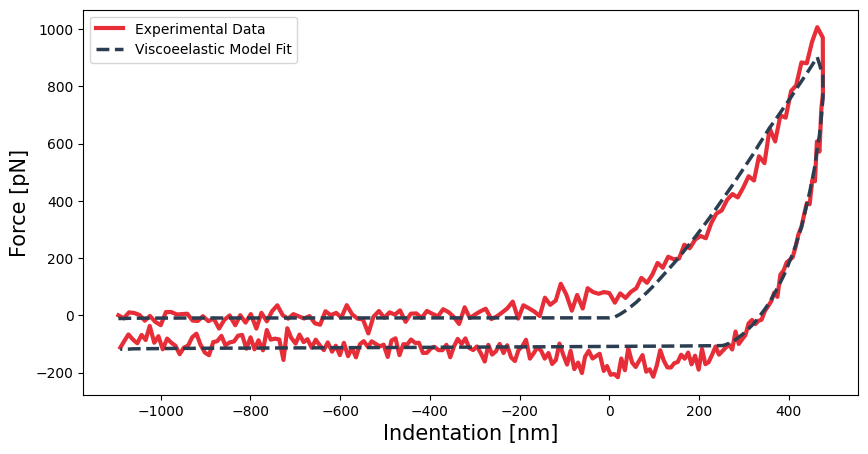

In [13]:
# Plot Ting Fit
plt.plot(
    (ind_fit[idxDown] - d0) * 1e9,
    force_fit[idxDown] * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)

plt.plot(
    (ind_fit[idxDown] - d0) * 1e9,
    ting_result.eval(
        time_fit[idxDown],
        force_fit[idxDown],
        ind_fit[idxDown],
        t0=1,
        idx_tm=ting_result.idx_tm,
        smooth_w=ting_result.smooth_w,
        v0t=ting_result.v0t,
        v0r=ting_result.v0r) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Viscoeelastic Model Fit'
)
plt.xlabel('Indentation [nm]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()

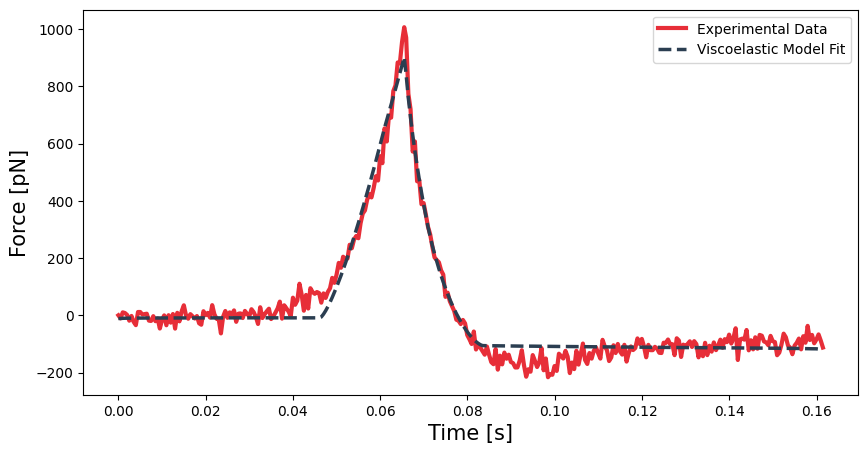

In [14]:
# Plot Ting Fit
plt.plot(
    time_fit[idxDown] - time_fit[idxDown][0],
    force_fit[idxDown] * 1e12,
    color='#E72E38',
    linewidth=3,
    label='Experimental Data'
)

plt.plot(
    time_fit[idxDown] - time_fit[idxDown][0],
    ting_result.eval(
        time_fit[idxDown],
        force_fit[idxDown],
        ind_fit[idxDown],
        t0=1,
        idx_tm=ting_result.idx_tm,
        smooth_w=ting_result.smooth_w,
        v0t=ting_result.v0t,
        v0r=ting_result.v0r) * 1e12,
    color='#2B3E51',
    linewidth=2.5,
    linestyle='--',
    label='Viscoelastic Model Fit'
)
plt.xlabel('Time [s]', fontsize = 15)
plt.ylabel('Force [pN]', fontsize = 15)
plt.legend()
plt.show()